In [ ]:
import pandas as pd
import numpy as np
import dask.dataframe as dd 
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns
import os
import re
import random
import datetime
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import utils
from sklearn import metrics, svm
from math import sqrt
from sklearn.metrics import r2_score
import xgboost as xgb
plt.style.use('fivethirtyeight')

In [4]:
# load the properties data
properties = pd.read_csv('properties_2016.csv', low_memory=False)
pd.options.display.max_columns = None
print properties.shape
properties.head()

(2985217, 58)


,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet12,finishedsquarefeet13,finishedsquarefeet15,finishedsquarefeet50,finishedsquarefeet6,fips,fireplacecnt,fullbathcnt,garagecarcnt,garagetotalsqft,hashottuborspa,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,poolcnt,poolsizesum,pooltypeid10,pooltypeid2,pooltypeid7,propertycountylandusecode,propertylandusetypeid,propertyzoningdesc,rawcensustractandblock,regionidcity,regionidcounty,regionidneighborhood,regionidzip,roomcnt,storytypeid,threequarterbathnbr,typeconstructiontypeid,unitcnt,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,10754147,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6037.0,NaN,NaN,NaN,NaN,NaN,NaN,34144442.0,-118654084.0,85768.0,NaN,NaN,NaN,NaN,NaN,010D,269.0,NaN,6.037800e+07,37688.0,3101.0,NaN,96337.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,2015.0,9.0,NaN,NaN,NaN,NaN
1,10759547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6037.0,NaN,NaN,NaN,NaN,NaN,NaN,34140430.0,-118625364.0,4083.0,NaN,NaN,NaN,NaN,NaN,0109,261.0,LCA11*,6.037800e+07,37688.0,3101.0,NaN,96337.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27516.0,2015.0,27516.0,NaN,NaN,NaN,NaN
2,10843547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,73026.0,NaN,NaN,73026.0,NaN,NaN,6037.0,NaN,NaN,NaN,NaN,NaN,NaN,33989359.0,-118394633.0,63085.0,NaN,NaN,NaN,NaN,NaN,1200,47.0,LAC2,6.037703e+07,51617.0,3101.0,NaN,96095.0,0.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,650756.0,1413387.0,2015.0,762631.0,20800.37,NaN,NaN,NaN
3,10859147,NaN,NaN,NaN,0.0,0.0,3.0,7.0,NaN,NaN,NaN,5068.0,NaN,NaN,5068.0,NaN,NaN,6037.0,NaN,NaN,NaN,NaN,NaN,NaN,34148863.0,-118437206.0,7521.0,NaN,NaN,NaN,NaN,NaN,1200,47.0,LAC2,6.037141e+07,12447.0,3101.0,27080.0,96424.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1948.0,1.0,NaN,571346.0,1156834.0,2015.0,585488.0,14557.57,NaN,NaN,NaN
4,10879947,NaN,NaN,NaN,0.0,0.0,4.0,NaN,NaN,NaN,NaN,1776.0,NaN,NaN,1776.0,NaN,NaN,6037.0,NaN,NaN,NaN,NaN,NaN,NaN,34194168.0,-118385816.0,8512.0,NaN,NaN,NaN,NaN,NaN,1210,31.0,LAM1,6.037123e+07,12447.0,3101.0,46795.0,96450.0,0.0,NaN,NaN,NaN,1.0,NaN,NaN,1947.0,NaN,NaN,193796.0,433491.0,2015.0,239695.0,5725.17,NaN,NaN,NaN


In [6]:
# Rename variables
properties.rename(index=str,columns={
"parcelid" : "id_parcel",
"basementsqft" : "area_basement",
"yearbuilt" : 'build_year',
"yardbuildingsqft17" : "area_patio",
"yardbuildingsqft26" : "area_shed",
"poolsizesum" : "area_pool",
"lotsizesquarefeet" : "lot_size",
"garagetotalsqft" : "area_garage",
"finishedfloor1squarefeet" : "area_firstfloor_finished",
"calculatedfinishedsquarefeet" : "area_total_calc",
"finishedsquarefeet6" : "area_base",
"finishedsquarefeet12" : "area_finished_living",
"finishedsquarefeet13" : "area_perimeter",
"finishedsquarefeet15" : "area_total_finished",
"finishedsquarefeet50" : "area_other",
"unitcnt" : "unit_count",
"numberofstories" : "number_of_stories",
"roomcnt" : "room_count",
"bathroomcnt" : "bath_count",
"bedroomcnt" : "bedroom_count",
"calculatedbathnbr" : "bath_count_calc",
"fullbathcnt" : "bath_full_count",
"threequarterbathnbr" : "bath_3qtrs_count",
"fireplacecnt" : "fireplace_count",
"poolcnt" : "pool_count",
"garagecarcnt" : "garage_stalls_count",
"regionidcounty" : "region_county",
"regionidcity" : "region_city",
"regionidzip" : "region_zip",
"regionidneighborhood" : "region_neighbor",
"taxvaluedollarcnt" : "home_value",
"structuretaxvaluedollarcnt" : "tax_building",
"landtaxvaluedollarcnt" : "tax_land",
"taxamount" : "tax_property",
"assessmentyear" : "tax_year",
"taxdelinquencyflag" : "tax_delinquency",
"taxdelinquencyyear" : "tax_delinquency_year",
"propertyzoningdesc" : "zoning_property",
"propertylandusetypeid" : "zoning_land_use",
"propertycountylandusecode" : "zoning_land_use_county",
"fireplaceflag" : "fireplace",
"hashottuborspa" : "tub",
"buildingqualitytypeid" : "bldg_quality",
"buildingclasstypeid" : "bldg_framing",
"typeconstructiontypeid" : "bldg_material",
"decktypeid" : "deck_type",
"storytypeid" : "story_type",
"airconditioningtypeid" : "airconditioning",
"architecturalstyletypeid" : "architectural_style"
},inplace=True)

In [7]:
# DATA TRANSFORMATIONS

# Calculated variables
properties['property_age'] = 2018 - properties['build_year']+1
properties['length_tax_delinq'] = 2018 - properties['tax_delinquency_year']+1
properties['total_rooms'] = properties['bath_count_calc'] + properties['bedroom_count']

# Dummy variables
properties['garage_yn'] = np.where((properties['garage_stalls_count'] > 0) | (properties['area_garage'] > 0),1,0)
properties['ac_yn'] = (properties['airconditioning']!=5)*1
properties['heat_yn'] = (properties['heatingorsystemtypeid']!=13)*1

properties['property_type'] = properties.zoning_land_use.replace({31 : "Mixed", 46 : "Other", 47 : "Mixed",
      246 : "Mixed", 247 : "Mixed", 248 : "Mixed",
      260 : "Home", 261 : "Home", 262 : "Home",
      263 : "Home", 264 : "Home", 265 : "Home",
      266 : "Home", 267 : "Home", 268 : "Home",
      269 : "Not Built", 270 : "Home", 271 : "Home",
      273 : "Home", 274 : "Other", 275 : "Home",
      276 : "Home", 279 : "Home", 290 : "Not Built",
      291 : "Not Built" }) 

properties['single_family_home'] = np.where(properties['zoning_land_use']==261, 1,0)

# Region density variables
properties['coords'] = properties['latitude']/(10^6) + properties['longitude']/(10^6)
zip_count = properties['region_zip'].value_counts().to_dict()
properties['zip_counts'] = properties['region_zip'].map(zip_count)
city_count = properties['region_city'].value_counts().to_dict()
properties['city_counts'] = properties['region_city'].map(city_count)
county_count = properties['region_county'].value_counts().to_dict()
properties['county_counts'] = properties['region_county'].map(county_count)

properties.drop(columns=['heatingorsystemtypeid','zoning_land_use',
                         'airconditioning','tax_delinquency_year','story_type','pooltypeid2',
                         'pooltypeid7','pooltypeid10'])

# Log variables 
properties['log_area_total_calc'] = np.log(properties['area_total_calc'].fillna(properties['area_total_calc'].median()))
properties['log_area_finished_living'] = np.log(properties['area_finished_living'].fillna(properties['area_finished_living'].median()))
properties['log_area_firstfloor_finished'] = np.log(properties['area_firstfloor_finished'])

properties.head()

,id_parcel,airconditioning,architectural_style,area_basement,bath_count,bedroom_count,bldg_framing,bldg_quality,bath_count_calc,deck_type,area_firstfloor_finished,area_total_calc,area_finished_living,area_perimeter,area_total_finished,area_other,area_base,fips,fireplace_count,bath_full_count,garage_stalls_count,area_garage,tub,heatingorsystemtypeid,latitude,longitude,lot_size,pool_count,area_pool,pooltypeid10,pooltypeid2,pooltypeid7,zoning_land_use_county,zoning_land_use,zoning_property,rawcensustractandblock,region_city,region_county,region_neighbor,region_zip,room_count,story_type,bath_3qtrs_count,bldg_material,unit_count,area_patio,area_shed,build_year,number_of_stories,fireplace,tax_building,home_value,tax_year,tax_land,tax_property,tax_delinquency,tax_delinquency_year,censustractandblock,property_age,length_tax_delinq,total_rooms,garage_yn,ac_yn,heat_yn,property_type,single_family_home,coords,zip_counts,city_counts,county_counts,log_area_total_calc,log_area_finished_living,log_area_firstfloor_finished
0,10754147,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6037.0,NaN,NaN,NaN,NaN,NaN,NaN,34144442.0,-118654084.0,85768.0,NaN,NaN,NaN,NaN,NaN,010D,269.0,NaN,6.037800e+07,37688.0,3101.0,NaN,96337.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,2015.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,1,Not Built,0,-7.042470e+06,8496.0,7506.0,2009362.0,7.360104,7.338888,NaN
1,10759547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6037.0,NaN,NaN,NaN,NaN,NaN,NaN,34140430.0,-118625364.0,4083.0,NaN,NaN,NaN,NaN,NaN,0109,261.0,LCA11*,6.037800e+07,37688.0,3101.0,NaN,96337.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27516.0,2015.0,27516.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,1,Home,1,-7.040411e+06,8496.0,7506.0,2009362.0,7.360104,7.338888,NaN
2,10843547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,73026.0,NaN,NaN,73026.0,NaN,NaN,6037.0,NaN,NaN,NaN,NaN,NaN,NaN,33989359.0,-118394633.0,63085.0,NaN,NaN,NaN,NaN,NaN,1200,47.0,LAC2,6.037703e+07,51617.0,3101.0,NaN,96095.0,0.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,650756.0,1413387.0,2015.0,762631.0,20800.37,NaN,NaN,NaN,NaN,NaN,NaN,0,1,1,Mixed,0,-7.033773e+06,9437.0,11686.0,2009362.0,11.198571,7.338888,NaN
3,10859147,NaN,NaN,NaN,0.0,0.0,3.0,7.0,NaN,NaN,NaN,5068.0,NaN,NaN,5068.0,NaN,NaN,6037.0,NaN,NaN,NaN,NaN,NaN,NaN,34148863.0,-118437206.0,7521.0,NaN,NaN,NaN,NaN,NaN,1200,47.0,LAC2,6.037141e+07,12447.0,3101.0,27080.0,96424.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1948.0,1.0,NaN,571346.0,1156834.0,2015.0,585488.0,14557.57,NaN,NaN,NaN,71.0,NaN,NaN,0,1,1,Mixed,0,-7.024029e+06,7916.0,670925.0,2009362.0,8.530702,7.338888,NaN
4,10879947,NaN,NaN,NaN,0.0,0.0,4.0,NaN,NaN,NaN,NaN,1776.0,NaN,NaN,1776.0,NaN,NaN,6037.0,NaN,NaN,NaN,NaN,NaN,NaN,34194168.0,-118385816.0,8512.0,NaN,NaN,NaN,NaN,NaN,1210,31.0,LAM1,6.037123e+07,12447.0,3101.0,46795.0,96450.0,0.0,NaN,NaN,NaN,1.0,NaN,NaN,1947.0,NaN,NaN,193796.0,433491.0,2015.0,239695.0,5725.17,NaN,NaN,NaN,72.0,NaN,NaN,0,1,1,Mixed,0,-7.015971e+06,7725.0,670925.0,2009362.0,7.482119,7.338888,NaN


In [8]:
# Trim top and bottom 1% of values
properties['log_home_value'] = np.log(properties['home_value']+0.00001)
high = np.percentile((properties['log_home_value'].dropna()),99)
low  = np.percentile((properties['log_home_value'].dropna()),1)
properties1 = properties[(properties['log_home_value'] > low) & (properties['log_home_value'] < high)].copy()
print properties1.shape

(2883810, 74)


In [9]:
# Split data into training and validation
from xgboost import XGBRegressor
data = properties1.select_dtypes(exclude=[object]).copy()
data.fillna(-1,inplace=True)
data['target'] = properties1['home_value']

X = data.drop(['id_parcel','tax_building','home_value','log_home_value','target','tax_property', 'bath_count', 'bedroom_count','bath_count_calc','bath_full_count',
               'longitude', 'latitude','coords','rawcensustractandblock','censustractandblock','build_year'],axis=1)
y = data['target']

xtrain,xtest,ytrain,ytest = train_test_split(X,y,test_size=0.33,random_state=42)

In [10]:
# Run XGBoost model
model = XGBRegressor(n_estimators = 1000,
                     learning_rate = 0.05,
                     max_depth = 10,
                     min_child_weight = 5)
eval_set = [(xtrain, ytrain), (xtest, ytest)]
%time model.fit(xtrain, ytrain, early_stopping_rounds=20, eval_metric=["mae"], eval_set=eval_set, verbose=True)
results = model.evals_result()

[0]	validation_0-mae:364274	validation_1-mae:363695
Multiple eval metrics have been passed: 'validation_1-mae' will be used for early stopping.

Will train until validation_1-mae hasn't improved in 100 rounds.
[1]	validation_0-mae:346074	validation_1-mae:345525
[2]	validation_0-mae:328783	validation_1-mae:328263
[3]	validation_0-mae:312357	validation_1-mae:311862
[4]	validation_0-mae:296752	validation_1-mae:296283
[5]	validation_0-mae:281930	validation_1-mae:281483
[6]	validation_0-mae:267850	validation_1-mae:267426
[7]	validation_0-mae:254476	validation_1-mae:254073
[8]	validation_0-mae:241774	validation_1-mae:241391
[9]	validation_0-mae:229710	validation_1-mae:229348
[10]	validation_0-mae:218252	validation_1-mae:217911
[11]	validation_0-mae:207373	validation_1-mae:207050
[12]	validation_0-mae:197045	validation_1-mae:196741
[13]	validation_0-mae:187239	validation_1-mae:186954
[14]	validation_0-mae:177932	validation_1-mae:177668
[15]	validation_0-mae:169102	validation_1-mae:168856
[16]

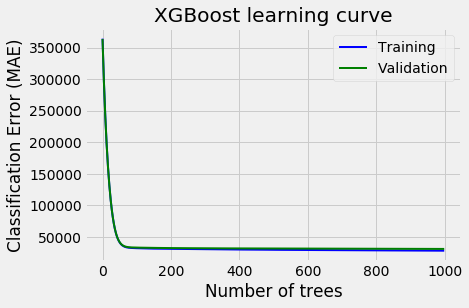

In [11]:
# Model learning curve 
fig, ax = plt.subplots()
rounds = len(results['validation_0']['mae'])
x_axis = range(0, rounds)
ax.plot(x_axis, results['validation_0']['mae'], 'b', linewidth=2, label='Training')
ax.plot(x_axis, results['validation_1']['mae'], 'g', linewidth=2, label='Validation')
ax.legend()
plt.xlabel("Number of trees")
plt.ylabel('Classification Error (MAE)')
plt.title('XGBoost learning curve')
plt.show()

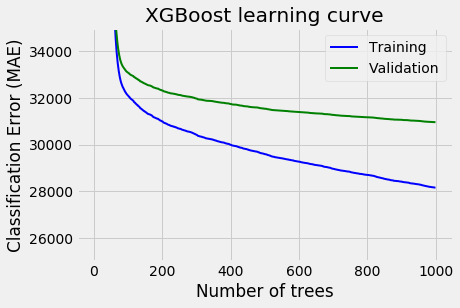

In [25]:
# Model learning curve 2
fig, ax = plt.subplots()
rounds = len(results['validation_0']['mae'])
x_axis = range(0, rounds)
ax.plot(x_axis, results['validation_0']['mae'], 'b', linewidth=2, label='Training')
ax.plot(x_axis, results['validation_1']['mae'], 'g', linewidth=2, label='Validation')
ax.legend()
plt.ylim(25000,35000)
plt.xlabel("Number of trees")
plt.ylabel('Classification Error (MAE)')
plt.title('XGBoost learning curve')
plt.show()

In [12]:
print("XGBoost MAE (Training):",np.mean(np.abs(model.predict(xtrain)-ytrain)))
print("XGBoost MAE (Validation):",np.mean(np.abs(model.predict(xtest)-ytest)))

r2 = r2_score(ytest, model.predict(xtest))
print("R2: %.4f" % r2)

('XGBoost MAE (Training):', 28158.621071760324)
('XGBoost MAE (Validation):', 30964.576316864168)
R2: 0.9683


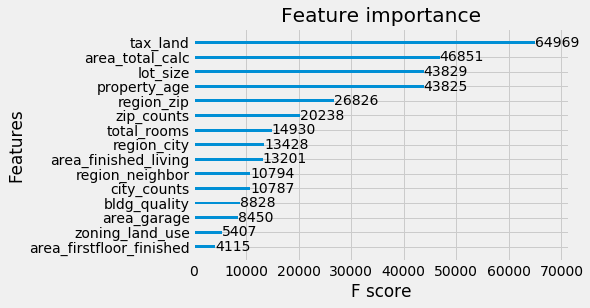

In [13]:
# Feature Importance Plot
from xgboost import plot_importance
plot_importance(model, max_num_features=15)
plt.show()

In [14]:
model.get_booster().get_score()

{'ac_yn': 21,
 'airconditioning': 3516,
 'architectural_style': 28,
 'area_base': 1911,
 'area_basement': 437,
 'area_finished_living': 13201,
 'area_firstfloor_finished': 4115,
 'area_garage': 8450,
 'area_other': 1269,
 'area_patio': 1784,
 'area_perimeter': 80,
 'area_pool': 1101,
 'area_shed': 296,
 'area_total_calc': 46851,
 'area_total_finished': 3622,
 'bath_3qtrs_count': 1172,
 'bldg_framing': 461,
 'bldg_material': 11,
 'bldg_quality': 8828,
 'city_counts': 10787,
 'deck_type': 471,
 'fips': 637,
 'fireplace_count': 1391,
 'garage_stalls_count': 1643,
 'garage_yn': 29,
 'heat_yn': 1,
 'heatingorsystemtypeid': 1854,
 'length_tax_delinq': 233,
 'log_area_finished_living': 1417,
 'log_area_total_calc': 1176,
 'lot_size': 43829,
 'number_of_stories': 2034,
 'pool_count': 2684,
 'pooltypeid10': 301,
 'pooltypeid2': 528,
 'pooltypeid7': 357,
 'property_age': 43825,
 'region_city': 13428,
 'region_county': 2179,
 'region_neighbor': 10794,
 'region_zip': 26826,
 'room_count': 3472,
 '

In [15]:
print(model.feature_importances_)

[9.33418330e-03 7.43336495e-05 1.16013596e-03 1.22385053e-03
 2.34363377e-02 1.25039823e-03 1.09243924e-02 1.24378785e-01
 3.50456610e-02 2.12381856e-04 9.61558893e-03 3.36890738e-03
 5.07327169e-03 1.69109053e-03 3.69278970e-03 4.36179247e-03
 2.24328339e-02 4.92194947e-03 1.16356060e-01 7.12541165e-03
 2.92290538e-03 7.99086760e-04 1.40172034e-03 9.47754073e-04
 1.43543594e-02 3.56482938e-02 5.78475092e-03 2.86556222e-02
 7.12169483e-02 9.21737310e-03 2.65477320e-06 3.11139436e-03
 2.92025070e-05 6.80152932e-03 4.73611569e-03 7.85812910e-04
 5.39980875e-03 3.90251662e-04 1.72477961e-01 1.10173086e-03
 1.16345435e-01 6.18562161e-04 3.96357663e-02 7.69884282e-05
 5.57502390e-05 2.65477320e-06 2.55123712e-03 5.37273027e-02
 2.86370385e-02 0.00000000e+00 3.12201330e-03 3.76181374e-03
 0.00000000e+00]


In [16]:
valid_data = pd.concat([xtest,ytest], axis=1)
valid_data['predicted'] = model.predict(xtest)
valid_data['pred_diff'] = (valid_data['target'] - valid_data['predicted'])

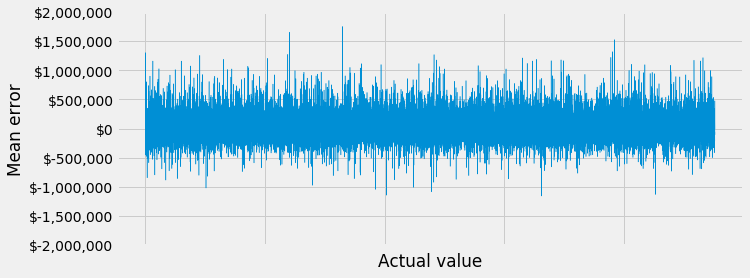

In [17]:
import matplotlib.ticker as mtick
fig, ax = plt.subplots(figsize=(10,4))
fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick) 
plt.ylim (-2000000,2000000)
plt.xlabel('Actual value')
plt.ylabel('Mean error')
(valid_data['pred_diff']).plot(linewidth=0.5)

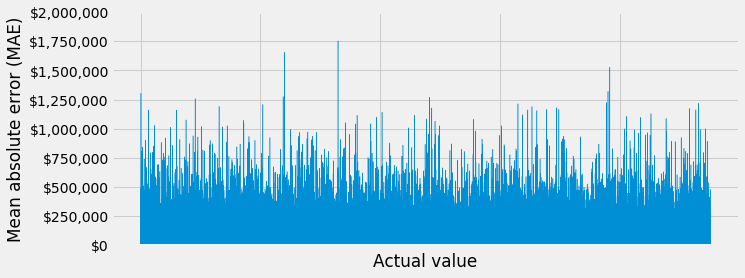

In [27]:
fig, ax = plt.subplots(figsize=(10,4))
fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick) 
plt.ylim (0,2000000)
plt.xlabel('Actual value')
plt.ylabel('Mean absolute error (MAE)')
np.abs(valid_data['pred_diff']).plot(linewidth=0.5)

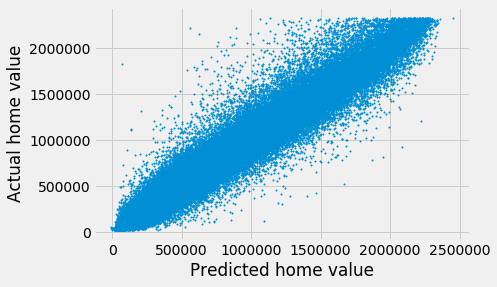

In [31]:
x=valid_data['predicted']
y=valid_data['target']
fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick)
plt.ylabel('Actual home value')
plt.xlabel('Predicted home value')
plt.scatter(x, y, s=2)

In [32]:
#  Check to see if the MAE values are different depending on home values (use +/- 1std)
std  = np.std(properties1['home_value'])
p50  = properties1['home_value'].quantile(0.50)
np.mean(np.abs( valid_data['pred_diff'].where((valid_data['target']>=p50 - std) & (valid_data['target']<=p50 + std)) ))

24087.73655730619